**<h2>1. Data Preprocessing</h2>**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/sample_data/potato_weather.csv', index_col=0)
df = df.dropna(axis=0)
df = df.drop(['Avg_Price'],axis=1)
df = df.drop(['Sup'],axis=1)
df = df.drop(['sobimul'],axis=1)
df = df.reset_index(drop=True)
df['Date'] = pd.to_datetime(df['Date'])
df['DayOfWeek'] = df['Date'].dt.dayofweek

In [ ]:
df['DayOfWeek'] = df['DayOfWeek'].astype('category')
df = pd.get_dummies(df, columns =['DayOfWeek'], prefix='W', drop_first=True)

In [ ]:
df.tail()

,Date,Rain,Wind,Temp,Oil,nongmul,Price,W_1,W_2,W_3,W_4
2390,2022-09-26,0.0,1.7,20.0,1889.31,8.7,415.0,0,0,0,0
2391,2022-09-27,0.0,1.6,20.9,1889.31,8.7,415.0,1,0,0,0
2392,2022-09-28,0.0,1.8,20.4,1889.31,8.7,415.0,0,1,0,0
2393,2022-09-29,0.0,1.4,20.4,1889.31,8.7,415.0,0,0,1,0
2394,2022-09-30,0.0,1.6,20.7,1889.31,8.7,415.0,0,0,0,1


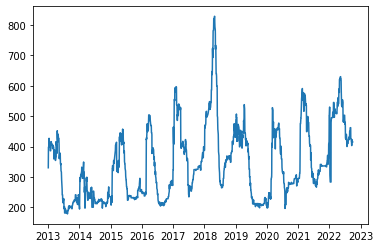

In [ ]:
plt.plot(df['Date'], df['Price'])

In [ ]:
train_split_idx = 2211
window_size = 21
future = 1 # 오늘이 안들어오는 것을 대비해서, 어제부터 21개로 내일을 예측함 

In [ ]:
x_train = df.iloc[:train_split_idx - window_size - future, 0:]
y_train = df.iloc[window_size + future:train_split_idx,[6]]

In [ ]:
test_start = train_split_idx - window_size - future
test_end = df.shape[0] - window_size - future

In [ ]:
x_test = df.iloc[test_start:test_end, 0:]
y_test = df.iloc[train_split_idx:, [6]]

In [ ]:
x_train_scaled = x_train.loc[:, 'Rain':]
x_test_scaled = x_test.loc[:, 'Rain':]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(x_train_scaled.values)
x_train_scaled.loc[:,:] = scaler.transform(x_train_scaled.values)
x_test_scaled.loc[:,:] = scaler.transform(x_test_scaled.values)

In [ ]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
train_data = timeseries_dataset_from_array(x_train_scaled, y_train, sequence_length=window_size, batch_size=1)
test_data = timeseries_dataset_from_array(x_test_scaled, y_test, sequence_length=window_size, batch_size=1)

In [ ]:
for batch in test_data.take(1):
  inputs, targets = batch

print("Input", inputs.numpy().shape)
print("Target:", inputs.numpy().shape)

Input (1, 21, 10)
Target: (1, 21, 10)


**<h2>2. LSTM Model </h2>**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow import keras

model = Sequential()
model.add(LSTM(32, batch_input_shape=(1, 21, 10), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(units=1, activation='linear'))

In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 32)                   5504      
                                                                 
 dropout (Dropout)           (1, 32)                   0         
                                                                 
 dense (Dense)               (1, 1)                    33        
                                                                 
Total params: 5,537
Trainable params: 5,537
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True)

In [ ]:
num_epochs = 200
history = LossHistory()
history.init()

for epoch_idx in range(num_epochs):
  print('epochs:' + str(epoch_idx))
  model.fit(train_data, validation_data=test_data, epochs=1, batch_size=1, verbose=2, shuffle=False, callbacks=[history, early_stopping_cb, checkpoint_cb])
  model.reset_states()

In [21]:
model = keras.models.load_model('/content/sample_data/first_best_model.h5')

**<h2>3. Testing Model </h2>**

In [22]:
y_pred = model.predict(test_data)
train_pred = model.predict(train_data)

2169/2169 [==============================] - 3s 1ms/step


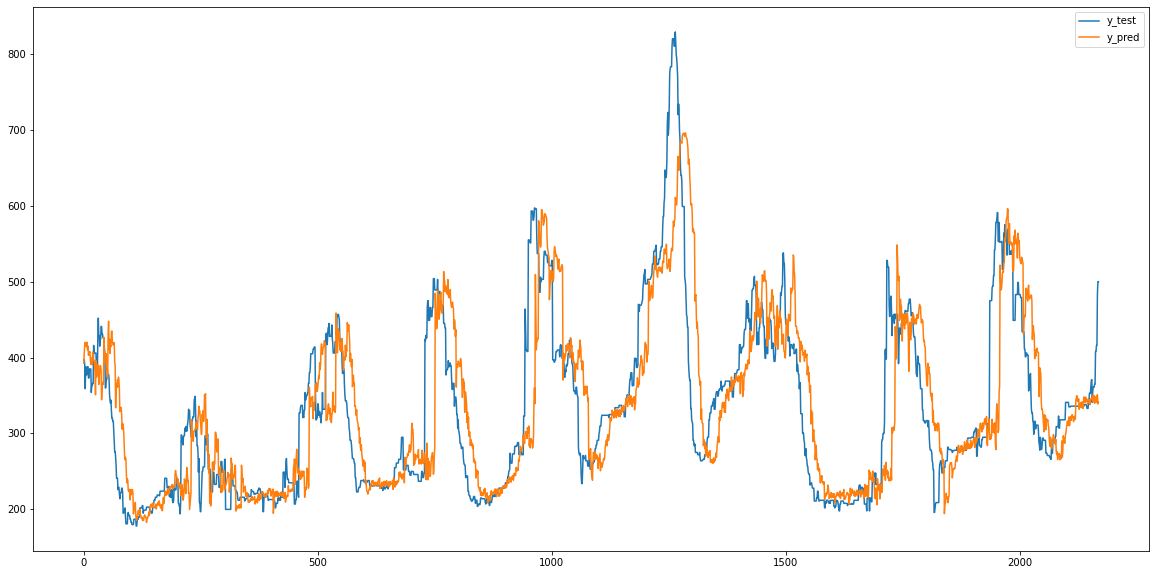

In [23]:
plt.figure(figsize=(20,10))
plt.plot(range(len(train_pred)), y_train[window_size-1:], label='y_test')
plt.plot(range(len(train_pred)), train_pred, label='y_pred')
plt.legend()
plt.show()

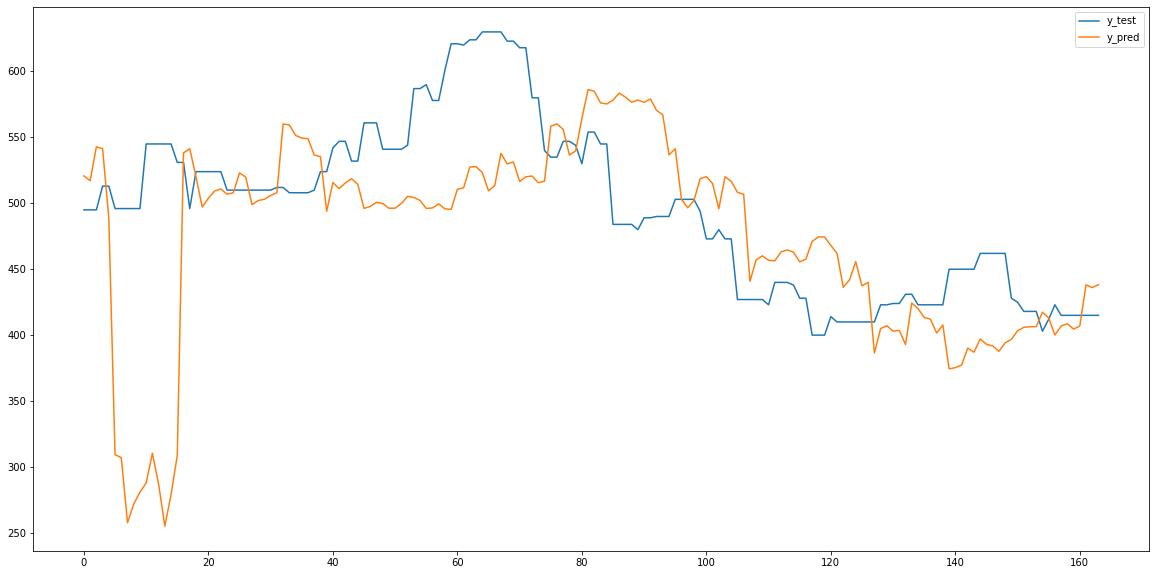

In [24]:
plt.figure(figsize=(20,10))
plt.plot(range(len(y_pred)), y_test[window_size-1:], label='y_test')
plt.plot(range(len(y_pred)), y_pred, label='y_pred')
plt.legend()
plt.show()

In [25]:
model.evaluate(train_data, batch_size=1)

2169/2169 [==============================] - 4s 1ms/step - loss: 521.4349 - mae: 13.8438


[521.4348754882812, 13.843766212463379]

In [26]:
model.evaluate(test_data, batch_size=1)

164/164 [==============================] - 0s 1ms/step - loss: 1773.8468 - mae: 28.5224


[1773.8468017578125, 28.522438049316406]

In [28]:
model.layers

In [43]:
weights_list = model.get_weights()
for i in weights_list[0]:
  print(i)

[ 9.80526358e-02  1.43562123e-01  4.23879117e-01  1.74155444e-01
 -5.18860109e-02  2.26814061e-01  3.75919819e-01  2.16736749e-01
 -3.42308320e-02  2.52559274e-01  3.09443861e-01  1.72443822e-01
  1.52942419e-01  2.68006086e-01  3.32933396e-01  2.02941194e-01
 -1.13049693e-01 -3.98559496e-02 -4.41858649e-01  5.40584981e-01
 -1.79726347e-01 -1.14890063e+00 -4.34534043e-01  3.88533354e-01
  3.98945302e-01  8.54133293e-02  1.86715513e-01  8.12758267e-01
  3.24396849e-01  7.30064064e-02  2.02071190e-01  1.19532138e-01
  4.37552601e-01  2.49759763e-01  1.33513317e-01  3.86531919e-01
  1.51491195e-01  4.24843550e-01  3.60421866e-01  4.52716917e-01
  3.52514833e-02  1.93101764e-01  2.81253904e-01  3.50100368e-01
 -9.23425481e-02  2.09350571e-01 -6.48214146e-02  1.19306222e-01
 -1.02311015e-01  6.11176016e-03 -6.26834214e-01  5.96886218e-01
 -1.66222230e-02 -1.34398758e+00 -6.95076212e-02  3.79566938e-01
  4.27162707e-01  1.12041913e-01 -1.05378870e-03 -5.73139906e-01
  3.67908835e-01 -2.95946